In [1]:
# Transformers installation
! pip install pymongo
! pip install transformers sentence_transformers datasets evaluate rouge_score -q
! pip install jiwer -q
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Create your HuggingFace Account for using AccessToken


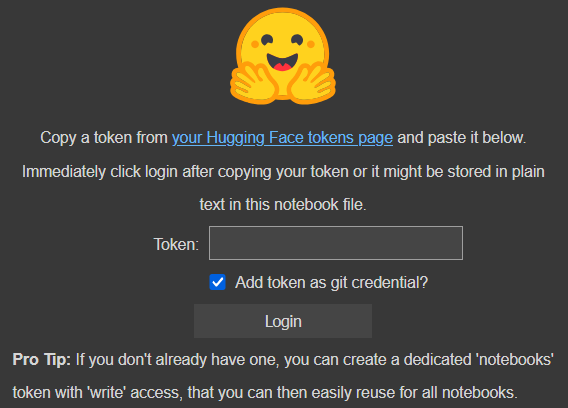

yourProfile -> Settings -> Access Tokens

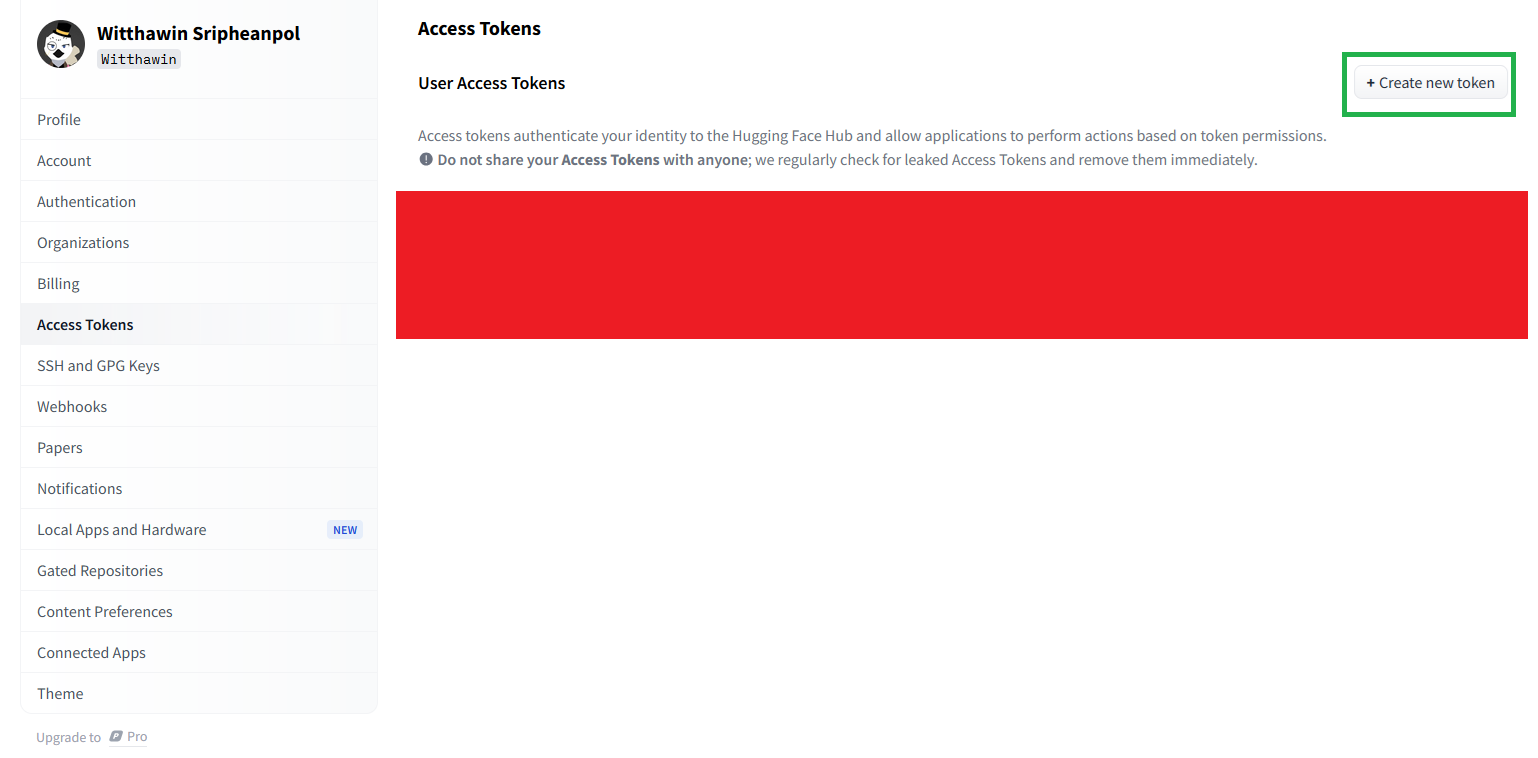

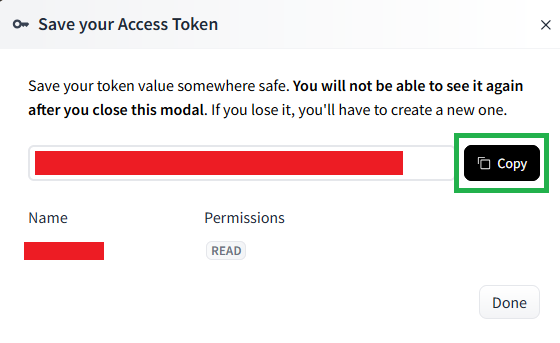

In [34]:
from huggingface_hub import notebook_login

notebook_login()

# Image Datasets

In [5]:
from datasets import load_dataset, DatasetDict

ds = load_dataset("reach-vb/pokemon-blip-captions")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [6]:
train_testvalid = ds['train'].train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'val': test_valid['train']})

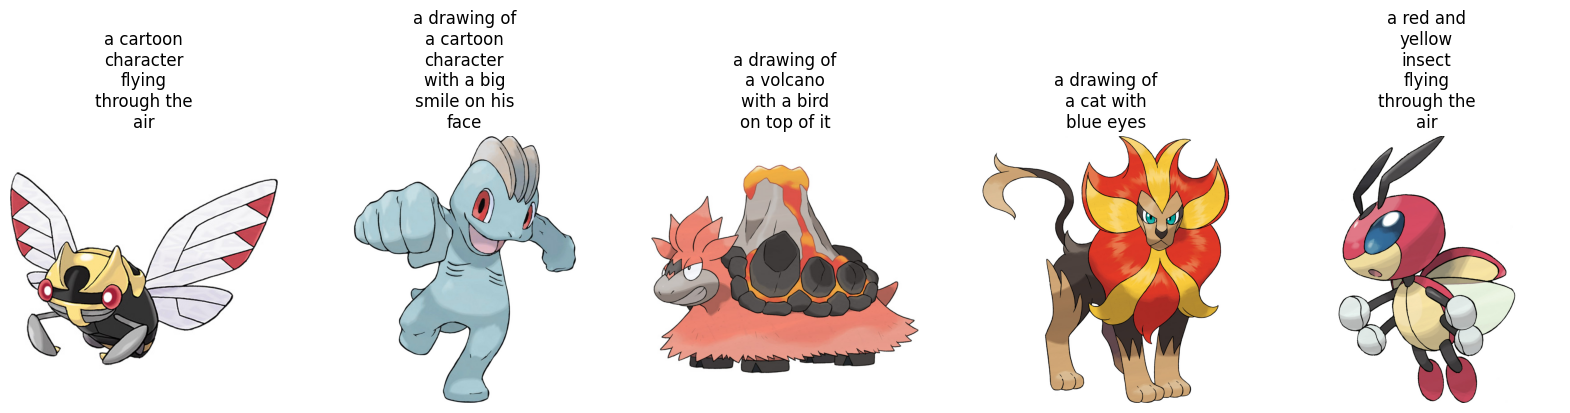

In [8]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(ds["train"][i]["image"]) for i in range(5)]
sample_captions = [ds["train"][i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

# Image Captioning

## Load Pretrain Model

In [9]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)


In [10]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model)

# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

In [11]:
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('vit-gpt-model/tokenizer_config.json',
 'vit-gpt-model/special_tokens_map.json',
 'vit-gpt-model/vocab.json',
 'vit-gpt-model/merges.txt',
 'vit-gpt-model/added_tokens.json',
 'vit-gpt-model/tokenizer.json')

In [12]:
from PIL import Image

# text preprocessing step
def tokenization_fn(captions, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(captions,
                      padding="max_length",
                      max_length=max_target_length).input_ids

    return labels

# image preprocessing step
def feature_extraction_fn(image_paths, check_image=True):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """

    model_inputs = {}

    # # Use for Local Image Dataset
    # if check_image:
    #     images = []
    #     to_keep = []
    #     for image_file in image_paths:
    #         try:
    #             img = Image.open(image_file)
    #             images.append(img)
    #             to_keep.append(True)
    #         except Exception:
    #             to_keep.append(False)
    # else:
    #     images = [Image.open(image_file) for image_file in image_paths]

    encoder_inputs = feature_extractor(images=image_paths, return_tensors="np")

    return encoder_inputs.pixel_values

def preprocess_fn(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['image']
    captions = examples['text']

    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)

    return model_inputs


In [13]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 666
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 84
    })
    val: Dataset({
        features: ['image', 'text'],
        num_rows: 83
    })
})

In [14]:
processed_dataset = ds.map(
    function=preprocess_fn,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=ds['train'].column_names
)

processed_dataset

Map:   0%|          | 0/666 [00:00<?, ? examples/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 666
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 84
    })
    val: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 83
    })
})

In [15]:
import evaluate
metric = evaluate.load("rouge")

In [16]:
import numpy as np

ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result


## Train Image-Captioning with Custom Datasets

In [17]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    output_dir="./pokemon-captioning-output",
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['val'],
    data_collator=default_data_collator,
)


In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.125757,45.929900,28.235400,45.143000,45.293000,10.000000
2,No log,0.121223,46.587100,27.432100,45.706500,45.734200,10.000000
3,No log,0.119407,42.960200,22.449300,40.431500,40.616500,8.530120
4,No log,0.118045,47.425600,26.919500,45.759200,45.807700,8.000000
5,No log,0.120982,48.554100,28.883500,45.622900,45.895400,8.530120
6,0.143200,0.120087,47.134500,26.327100,44.963600,45.120700,9.265060
7,0.143200,0.123623,46.930000,24.904800,43.315700,43.386900,9.662651
8,0.143200,0.141139,46.515500,25.956400,42.500500,42.607300,8.939759
9,0.143200,0.145349,43.524700,22.484000,40.870000,40.965800,9.915663
10,0.143200,0.171045,46.026400,24.523300,42.858300,42.933000,9.060241


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end

KeyboardInterrupt: 

## Save custom model to HuggingFace Hub

In [20]:
trainer.save_model("./pokemon-captioning-output")
tokenizer.save_pretrained("./pokemon-captioning-output")

('./pokemon-captioning-output/tokenizer_config.json',
 './pokemon-captioning-output/special_tokens_map.json',
 './pokemon-captioning-output/vocab.json',
 './pokemon-captioning-output/merges.txt',
 './pokemon-captioning-output/added_tokens.json',
 './pokemon-captioning-output/tokenizer.json')

In [43]:
from transformers import pipeline

image_captioner = pipeline("image-to-text", model="./pokemon-captioning-output")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


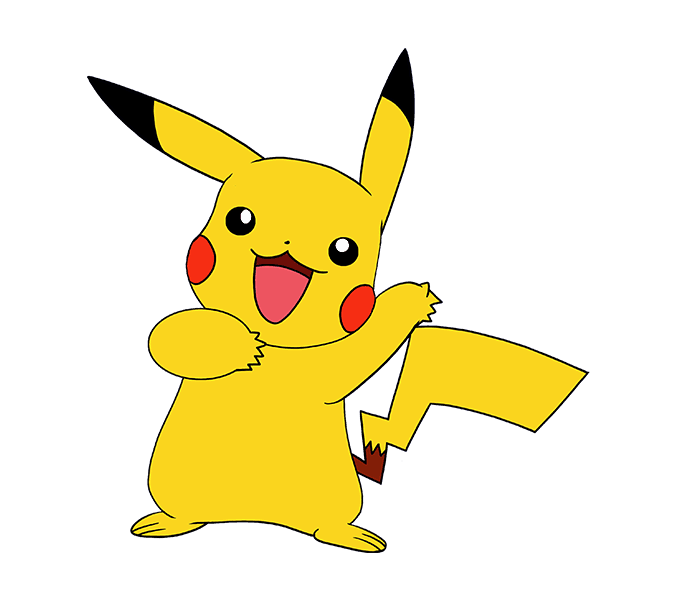

In [28]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://i.pinimg.com/originals/98/16/a5/9816a5f7c4fdb8ba3397f4e2b83cba28.png"

response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img

In [29]:
image_captioner(img)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a cartoon sunflower with a happy face'}]

In [46]:
image_captioner.push_to_hub("Pokemon-Captioner")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Witthawin/Pokemon-Captioner/commit/123c56472bb1be5200b45eb409d0e217eeb1f267', commit_message='Upload ImageToTextPipeline', commit_description='', oid='123c56472bb1be5200b45eb409d0e217eeb1f267', pr_url=None, pr_revision=None, pr_num=None)

## Load your Pipeline from HuggingFace Hub

In [48]:
image_cap = pipeline("image-to-text", model='Witthawin/Pokemon-Captioner')

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [49]:
image_cap(img)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a cartoon sunflower with a happy face'}]

# Prepare Captioning Datasets for RAG

In [52]:
import pandas as pd

In [50]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 666
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 84
    })
    val: Dataset({
        features: ['image', 'text'],
        num_rows: 83
    })
})

In [54]:
train_df = pd.DataFrame(ds["train"])
train_df

,image,text
0,<PIL.Image.Image image mode=RGB size=431x431 a...,a cartoon character flying through the air
1,<PIL.Image.Image image mode=RGB size=1032x1032...,a drawing of a cartoon character with a big sm...
2,<PIL.Image.Image image mode=RGB size=600x600 a...,a drawing of a volcano with a bird on top of it
3,<PIL.Image.Image image mode=RGB size=1280x1280...,a drawing of a cat with blue eyes
4,<PIL.Image.Image image mode=RGB size=1280x1280...,a red and yellow insect flying through the air
...,...,...
661,<PIL.Image.Image image mode=RGB size=1280x1280...,a green and yellow cartoon character with big ...
662,<PIL.Image.Image image mode=RGB size=431x431 a...,a cartoon character with a bat on his back
663,<PIL.Image.Image image mode=RGB size=431x431 a...,a drawing of a dragon sitting on its hind legs
664,<PIL.Image.Image image mode=RGB size=1280x1280...,a very cute looking pokemon with big wings


## Image Captioning

In [57]:
train_df["caption"] = train_df["image"].apply(lambda x : image_cap(x)[0])
train_df

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


,image,text,caption
0,<PIL.Image.Image image mode=RGB size=431x431 a...,a cartoon character flying through the air,{'generated_text': 'a cartoon character flying...
1,<PIL.Image.Image image mode=RGB size=1032x1032...,a drawing of a cartoon character with a big sm...,{'generated_text': 'a drawing of a cartoon cha...
2,<PIL.Image.Image image mode=RGB size=600x600 a...,a drawing of a volcano with a bird on top of it,{'generated_text': 'a drawing of a volcano wit...
3,<PIL.Image.Image image mode=RGB size=1280x1280...,a drawing of a cat with blue eyes,{'generated_text': 'a drawing of a cat with bl...
4,<PIL.Image.Image image mode=RGB size=1280x1280...,a red and yellow insect flying through the air,{'generated_text': 'a red and yellow insect fl...
...,...,...,...
661,<PIL.Image.Image image mode=RGB size=1280x1280...,a green and yellow cartoon character with big ...,{'generated_text': 'a green and yellow cartoon...
662,<PIL.Image.Image image mode=RGB size=431x431 a...,a cartoon character with a bat on his back,{'generated_text': 'a cartoon character with a...
663,<PIL.Image.Image image mode=RGB size=431x431 a...,a drawing of a dragon sitting on its hind legs,{'generated_text': 'a drawing of a dragon sitt...
664,<PIL.Image.Image image mode=RGB size=1280x1280...,a very cute looking pokemon with big wings,{'generated_text': 'a very cute looking pokemo...


In [60]:
train_df["caption"][0]

{'generated_text': 'a cartoon character flying through the air'}

In [65]:
train_df["caption"] = train_df["caption"].apply(lambda x: x["generated_text"])

## Convert PIL.Image to Base64

In [73]:
import base64
from io import BytesIO

def convertPIL2base64(pil_image):
  buffered = BytesIO()
  pil_image.save(buffered, format="JPEG")
  img_str = base64.b64encode(buffered.getvalue())
  return img_str

In [76]:
train_df["image64"] = train_df["image"].apply(convertPIL2base64)

## Text Embedding

In [66]:
from sentence_transformers import SentenceTransformer

# https://huggingface.co/thenlper/gte-large
embedding_model = SentenceTransformer("thenlper/gte-large")


def get_embedding(text: str) -> list[float]:
    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    embedding = embedding_model.encode(text)

    return embedding.tolist()

train_df["embedding"] = train_df["caption"].apply(get_embedding)

train_df.head()

,image,text,caption,embedding
0,<PIL.Image.Image image mode=RGB size=431x431 a...,a cartoon character flying through the air,a cartoon character flying through the air,"[0.005627399310469627, 0.001607067184522748, -..."
1,<PIL.Image.Image image mode=RGB size=1032x1032...,a drawing of a cartoon character with a big sm...,a drawing of a cartoon character with a big sm...,"[0.012079037725925446, 0.01146671362221241, -0..."
2,<PIL.Image.Image image mode=RGB size=600x600 a...,a drawing of a volcano with a bird on top of it,a drawing of a volcano with a bird on top of it,"[-0.013320599682629108, 0.01324450597167015, 0..."
3,<PIL.Image.Image image mode=RGB size=1280x1280...,a drawing of a cat with blue eyes,a drawing of a cat with blue eyes,"[-0.01210741326212883, -0.010515757836401463, ..."
4,<PIL.Image.Image image mode=RGB size=1280x1280...,a red and yellow insect flying through the air,a red and yellow insect flying through the air,"[-0.02127719856798649, -0.009701680392026901, ..."


# Setup Vector Database on MongoDB

## Initial Project on MongoDB Atlas

Initial MongoDB Atlas
1. Create Organization
2. Create Project
3. Create Cluster

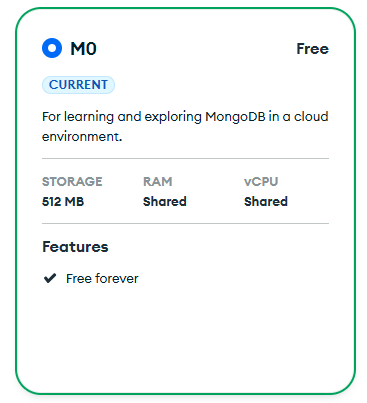

## Network Access Setup

Project -> Network -> Access

*Config* IP Address to 0.0.0.0/0 for Using on any Colab

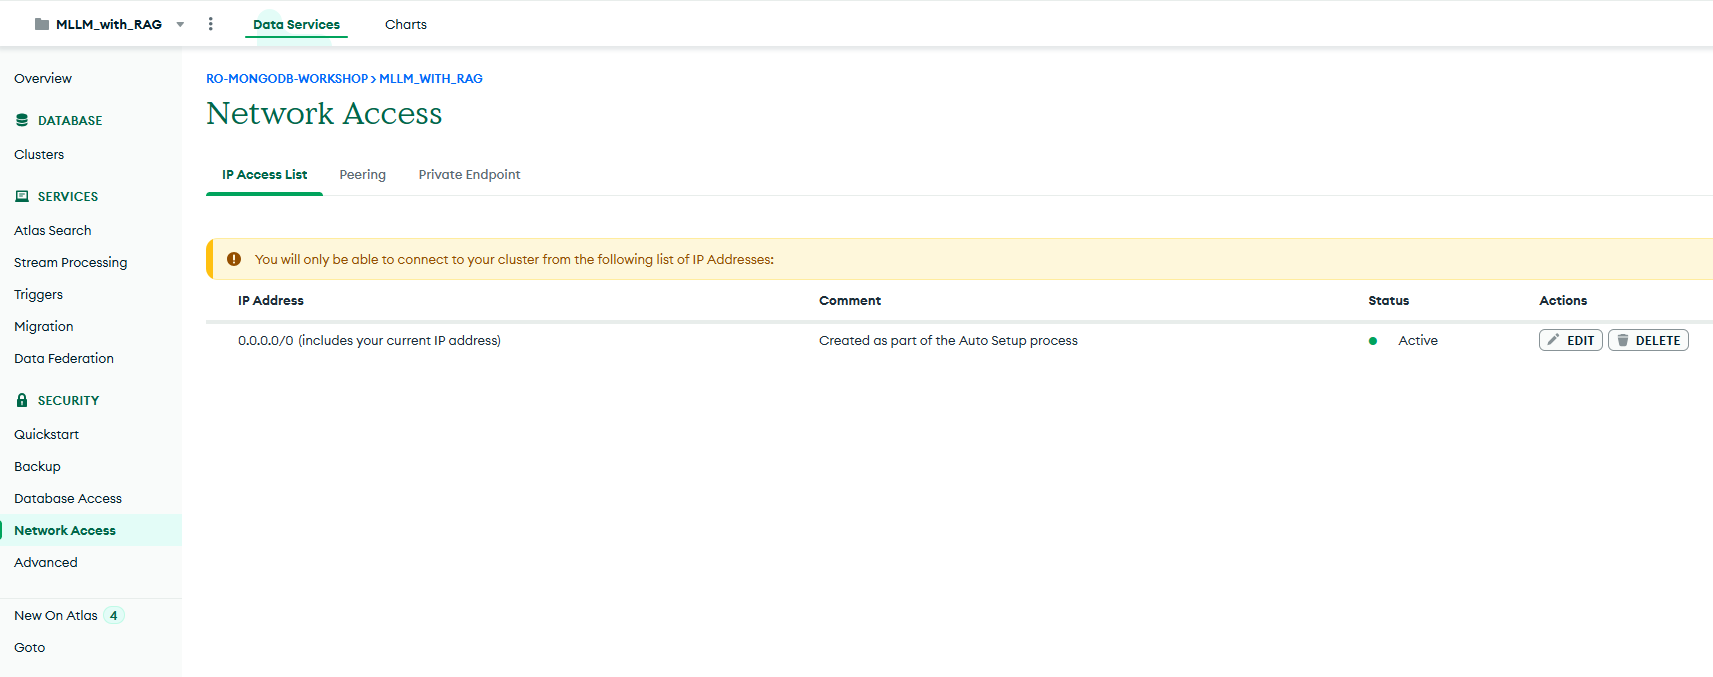

## Connection Config

Project -> Cluster -> setup Username & Password



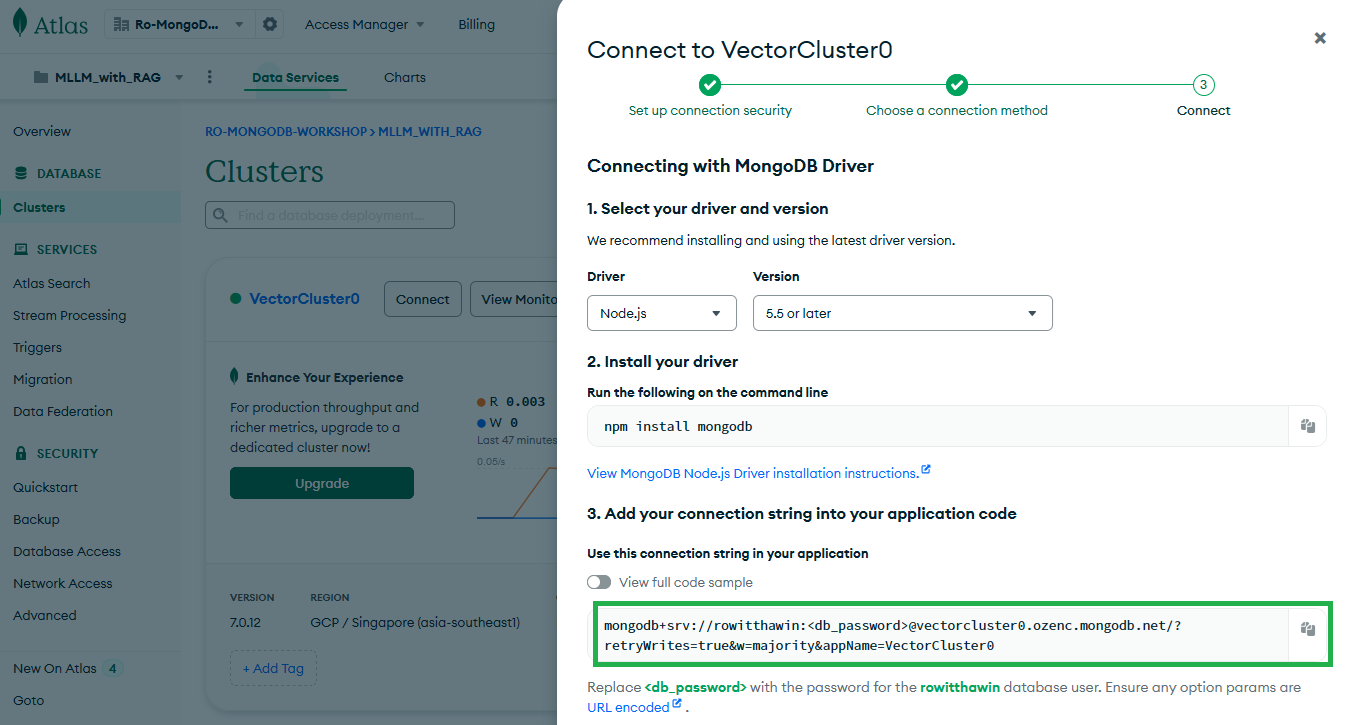

## Config URL to Colab for Connection

In [ ]:
mongo_uri = "" # YOUR_MONGODB_URL

In [71]:
import pymongo
from google.colab import userdata

def get_mongo_client(mongo_uri):
  """Establish connection to the MongoDB."""
  try:
    client = pymongo.MongoClient(mongo_uri, appname="devrel.content.python")
    print("Connection to MongoDB successful")
    return client
  except pymongo.errors.ConnectionFailure as e:
    print(f"Connection failed: {e}")
    return None

if not mongo_uri:
  print("MONGO_URI not set in environment variables")

mongo_client = get_mongo_client(mongo_uri)

# Ingest data into MongoDB
db = mongo_client['images']
collection = db['pokemon_images']

Connection to MongoDB successful


In [79]:
train_df[["image64", "caption", "embedding"]].head(10)

,image64,caption,embedding
0,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a cartoon character flying through the air,"[0.005627399310469627, 0.001607067184522748, -..."
1,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a drawing of a cartoon character with a big sm...,"[0.012079037725925446, 0.01146671362221241, -0..."
2,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a drawing of a volcano with a bird on top of it,"[-0.013320599682629108, 0.01324450597167015, 0..."
3,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a drawing of a cat with blue eyes,"[-0.01210741326212883, -0.010515757836401463, ..."
4,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a red and yellow insect flying through the air,"[-0.02127719856798649, -0.009701680392026901, ..."
5,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a green and yellow toy with a red nose,"[0.003142820904031396, 0.01044025830924511, -0..."
6,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a drawing of a deer standing under a tree,"[-0.009986662305891514, -0.0029220087453722954..."
7,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a cartoon bird with a bandanna on its head,"[-0.0020674755796790123, -0.006309776566922665..."
8,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a drawing of a red and black pokemon,"[-0.011684034951031208, -0.009082254022359848,..."
9,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a green and brown animal with a tree on top of it,"[-0.016542496159672737, -0.014706119894981384,..."


In [80]:
documents = train_df[["image64", "caption", "embedding"]].to_dict("records")
collection.insert_many(documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


You can see data in Atlas Mornitoring

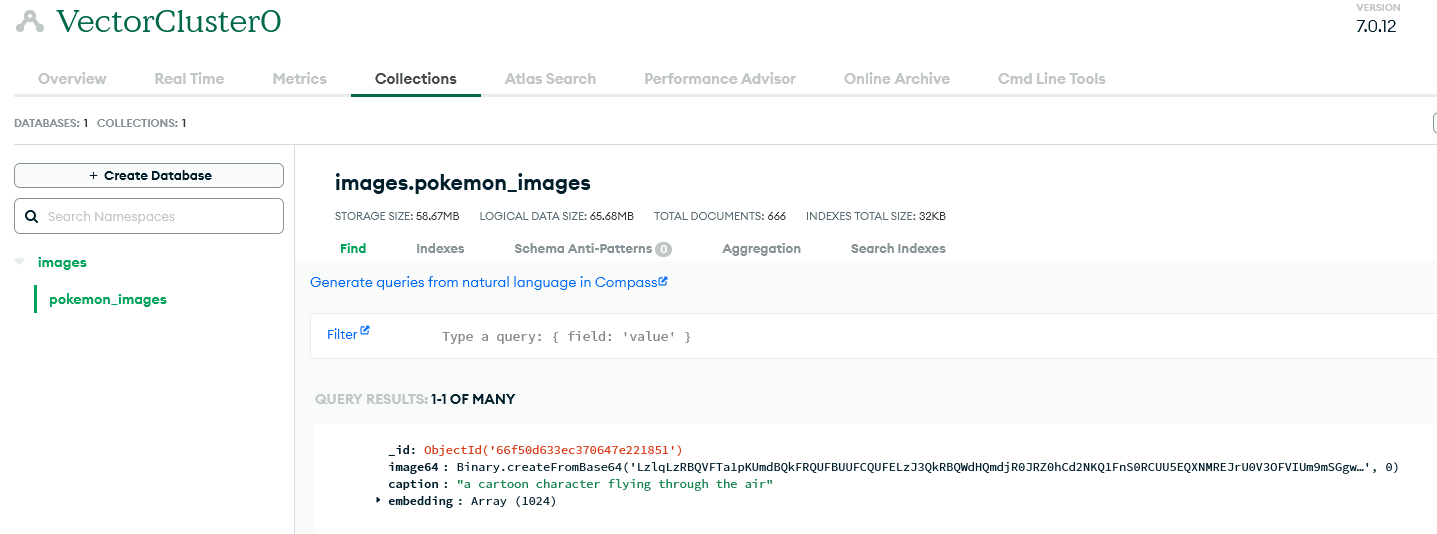

# Vector Searching with MongoDB

## Config Atlas Search

Project -> Clusters -> Atlas Search

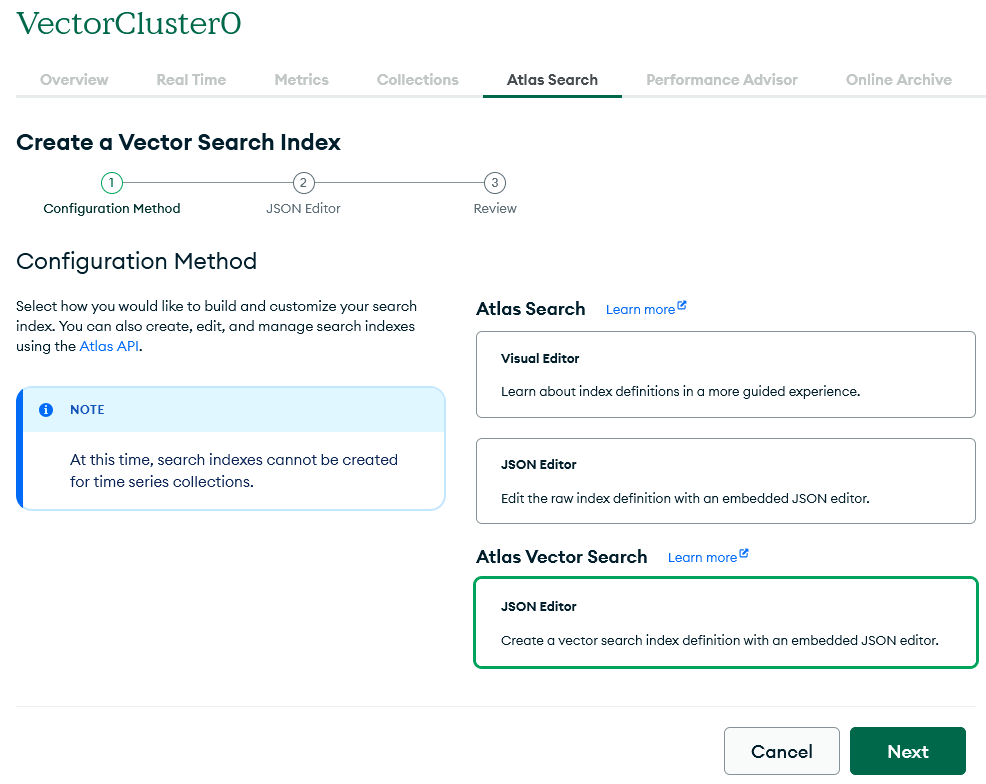

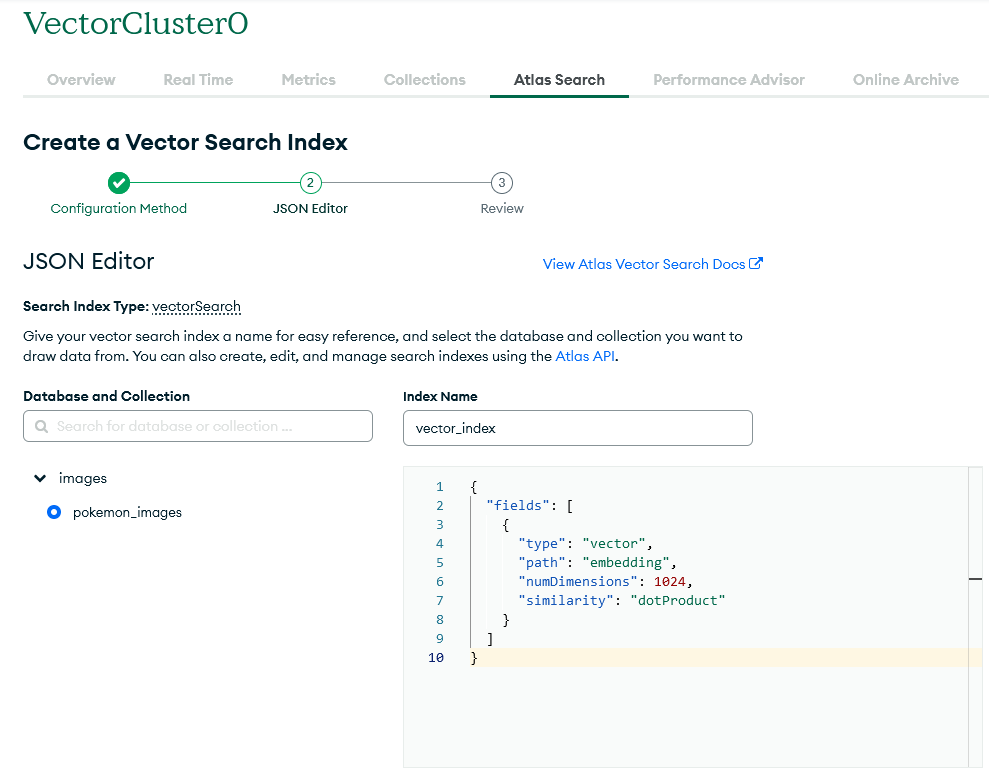

*Config with your datasets*

Ref : https://www.mongodb.com/docs/atlas/atlas-search/create-index/

## Vector Searching

In [89]:
def vector_search(user_query, collection):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search pipeline
    vector_search_stage = {
        "$vectorSearch": {
            "index": "vector_index",
            "queryVector": query_embedding,
            "path": "embedding",
            "numCandidates": 150,  # Number of candidate matches to consider
            "limit": 4  # Return top 4 matches
        }
    }

    unset_stage = {
        "$unset": "embedding"  # Exclude the 'embedding' field from the results
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "image64": 1,
            "caption": 1,
            "score": {
                "$meta": "vectorSearchScore"  # Include the search score
            }
        }
    }

    pipeline = [vector_search_stage, unset_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

In [98]:
query = "I want to see your Pikachu"
res = vector_search(query, collection)

In [103]:
res_df = pd.DataFrame(res)
res_df

,image64,caption,score
0,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a very cute looking pokemon pikachu with big eyes,0.949880
1,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a yellow and black pokemon pikachu with pink eyes,0.943697
2,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a drawing of a pikachu with blue eyes,0.942048
3,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgH...,a pikachu holding a cell phone and wearing a b...,0.938940


In [104]:
for result in res:
  Image.open(BytesIO(base64.b64decode(result["image64"])))

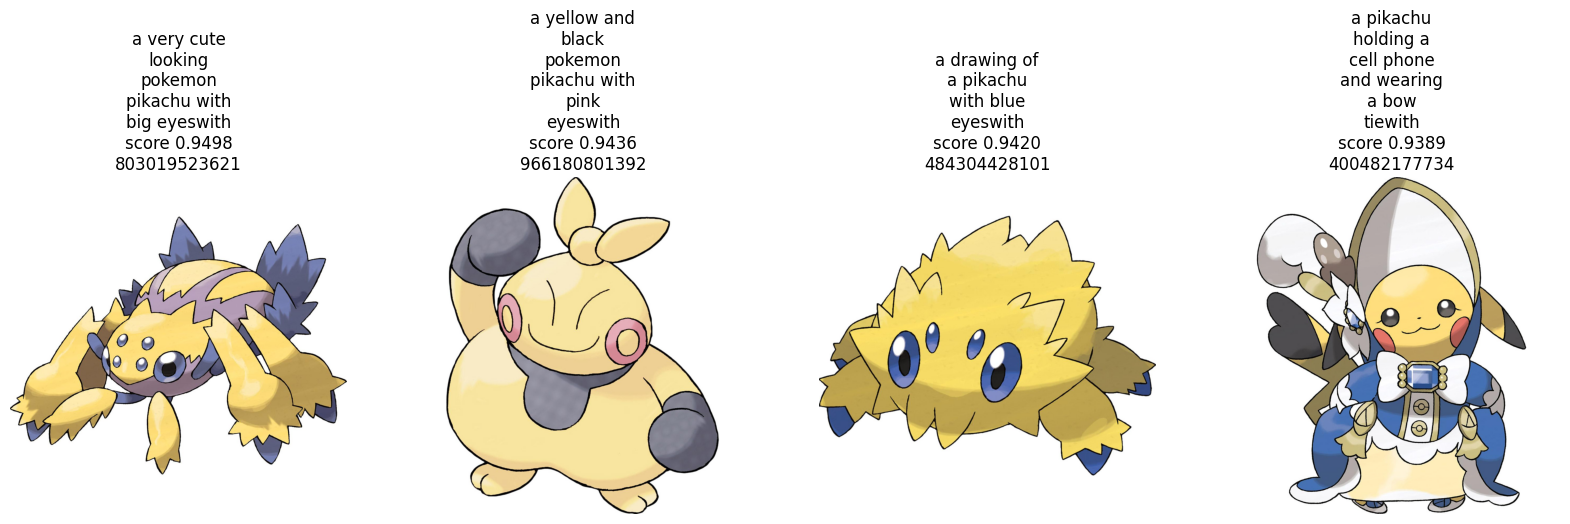

In [105]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(Image.open(BytesIO(base64.b64decode(result["image64"])))) for result in res]
sample_captions = [result["caption"]+"with score "+str(result["score"]) for result in res]
plot_images(sample_images_to_visualize, sample_captions)